In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, balanced_accuracy_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix, roc_curve


In [164]:
# 1. Відкрити та зчитати дані з наданого файлу.
df = pd.read_csv('KM-11-3.csv')
df.columns = df.columns.str.strip()
df.dtypes

GT             int64
Model_1_0    float64
Model_2_1    float64
dtype: object

In [165]:
# 2. Визначити  збалансованість  набору  даних.  Вивести  кількість  об’єктів кожного класу.
df['GT'].value_counts()

GT
0    2200
1    2200
Name: count, dtype: int64

In [166]:
metric_name = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC', 'Balanced Accuracy', 'Youden J', 'PR AUC', 'ROC AUC', 'number']

In [167]:
# a. Обчислити всі метрики (Accuracy, Precision, Recall, F-Scores, 
# Matthews Correlation Coefficient, Balanced Accuracy, Youden’s J 
# statistics, Area Under Curve for Precision-Recall Curve, Area 
# Under Curve for Receiver Operation Curve) для кожної моделі при
# різних значеннях порогу класифікатора (крок зміни порогу
# обрати самостійно).

def calculate_metrics(df, metric_name):
    y_true = df['GT']
    
    metrics = pd.DataFrame(columns=metric_name)
    count = 0
    
    for model in ['Model_1_0', 'Model_2_1']:
        y_pred_proba = df[model]

        accuracy, precision, recall, f1, mcc, balanced_accuracy, youden_j, auc_pr, auc_roc, number_list = [],[],[],[],[],[],[],[],[],[]
        
        for threshold in np.arange(0, 1.1, 0.1):
            y_pred = (y_pred_proba > threshold).astype(int)

            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

            accuracy.append(accuracy_score(y_true, y_pred))
            precision.append(precision_score(y_true, y_pred, zero_division=0))
            recall.append(recall_score(y_true, y_pred))
            f1.append(f1_score(y_true, y_pred))
            mcc.append(matthews_corrcoef(y_true, y_pred))
            balanced_accuracy.append(balanced_accuracy_score(y_true, y_pred))
            youden_j.append(tp / (tp + fn) + tn / (tn + fp) - 1)
            number_list.append(y_pred.sum())

        precision_pr, recall_pr, _ = precision_recall_curve(y_true, y_pred_proba)
        auc_pr.append(auc(recall_pr, precision_pr))

        auc_roc.append(roc_auc_score(y_true, y_pred_proba))

        metrics.loc[count, 'Accuracy'] = accuracy
        metrics.loc[count, 'Precision'] = precision
        metrics.loc[count, 'Recall'] = recall
        metrics.loc[count, 'F1-Score'] = f1
        metrics.loc[count, 'MCC'] = mcc
        metrics.loc[count, 'Balanced Accuracy'] = balanced_accuracy
        metrics.loc[count, 'Youden J'] = max(youden_j)
        metrics.loc[count, 'PR AUC'] = auc_pr[0]
        metrics.loc[count, 'ROC AUC'] = auc_roc[0]
        metrics.loc[count, 'number'] = number_list

        count += 1

    return metrics.T

In [168]:
metric_result = calculate_metrics(df, metric_name)
metric_result

,0,1
Accuracy,"[0.5, 0.17386363636363636, 0.17386363636363636...","[0.5, 0.9834090909090909, 0.9863636363636363, ..."
Precision,"[0.5, 0.2573554277984444, 0.2573554277984444, ...","[0.5, 0.9691221879135421, 0.9759786476868327, ..."
Recall,"[1.0, 0.3459090909090909, 0.3459090909090909, ...","[1.0, 0.9986363636363637, 0.9972727272727273, ..."
F1-Score,"[0.6666666666666666, 0.29513282916424277, 0.29...","[0.6666666666666666, 0.9836579359749272, 0.986..."
MCC,"[0.0, -0.6946932407157095, -0.6946932407157095...","[0.0, 0.9672668458813284, 0.9729588805893487, ..."
Balanced Accuracy,"[0.5, 0.17386363636363636, 0.17386363636363636...","[0.5, 0.9834090909090909, 0.9863636363636363, ..."
Youden J,0.0,0.982273
PR AUC,0.305651,0.992247
ROC AUC,0.002591,0.996237
number,"[4400, 2957, 2957, 2232, 2186, 2184, 2180, 217...","[4400, 2267, 2248, 2233, 2227, 2224, 2221, 221..."


In [169]:
def diagram(df, metric_result):
    for models in metric_result.columns:
        fig, ax = plt.subplots()
        metrics = list(metric_result.index)
        xs = np.arange(0, 1.1, 0.1)
        metrics.remove('number')
        for j, i in enumerate(metrics):
            ys = metric_result.loc[i, models]
            if isinstance(ys, float):
                plt.plot([-0.1, 1.1], [ys]*2, label=i)
            else:
                plt.plot(xs, ys, label=i)
                max_index = np.argmax(ys)
                max_value = ys[max_index]
                plt.scatter(xs[max_index], max_value, color=plt.gca().lines[-1].get_color())
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Values')
        plt.legend(loc='lower center', fontsize='small')  
        plt.show()

    for models in metric_result.columns:
        fig, ax = plt.subplots()
        metrics = list(metric_result.index)
        xs = metric_result.loc['number', models]
        metrics.remove('number')
        for j, i in enumerate(metrics):
            ys = metric_result.loc[i, models]
            if isinstance(ys, float):
                plt.plot([-0.1, 1.1], [ys]*2, label=i)
            else:
                plt.plot(xs, ys, label=i)
                plt.plot([-0.1, 1.1], [np.max(ys)]*2, '--')
        ax.set_xlabel('Number')
        ax.set_ylabel('Values')
        plt.legend()
        plt.show()

    def intersection(x1, y1, x2, y2):
        f1 = interp1d(x1, y1)
        f2 = interp1d(x2, y2)
        intersection_x = brentq(lambda x: f1(x) - f2(x), 0, 1)
        intersection_y = f1(intersection_x)
        return intersection_x, intersection_y


    for m in df.columns[1:]:
        fig, axes = plt.subplots(ncols = 2, figsize=(15, 5))
        precision, recall, thresholds = precision_recall_curve(df['GT'], df[m], pos_label=1)
        axes[0].plot(recall, precision)
        axes[0].set_ylabel('precision')
        axes[0].set_xlabel('recall')
        axes[0].set_title('PR curve')
        axes[0].set_ylim(-0.1, 1.1)
        axes[0].set_xticks(np.arange(0, 1.1, 0.1))
        
        intersection_x, intersection_y = intersection(recall, precision, [0, 1], [0, 1])
        axes[0].scatter(intersection_x, intersection_y)
        prob_1 = (df['GT'] == 1).mean()
        axes[0].plot([0,1], [prob_1, prob_1], '--')
        axes[0].plot([0,1], [0, 1], '--')

        fpr, tpr, thresholds = roc_curve(df['GT'], df[m], pos_label=1)
        axes[1].plot(fpr, tpr)
        axes[1].set_ylabel('TPR')
        axes[1].set_xlabel('FPR')
        axes[1].set_title('ROC curve')
        axes[1].plot([0,1], [0, 1], '--')

        index = np.argmin(np.abs(tpr + fpr - 1))

        axes[1].scatter(fpr[index], tpr[index])

        plt.show()      

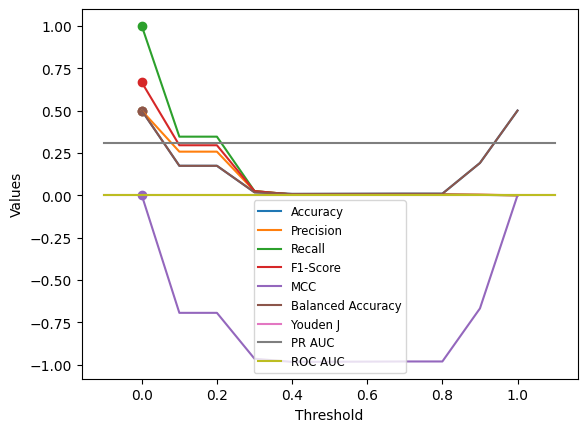

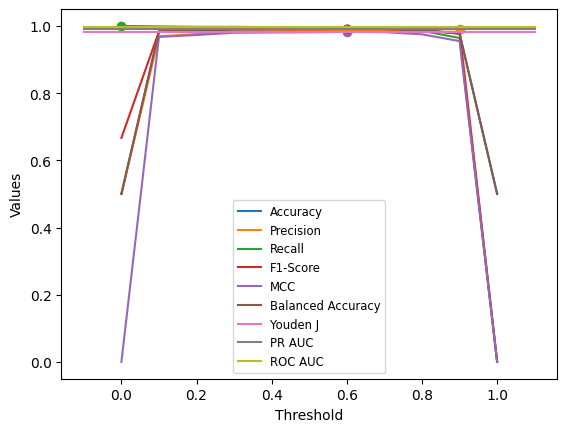

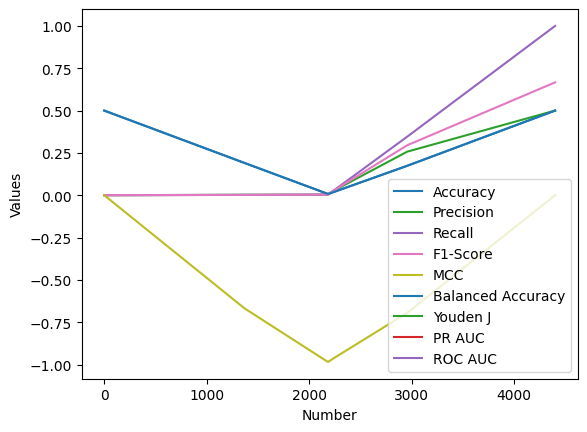

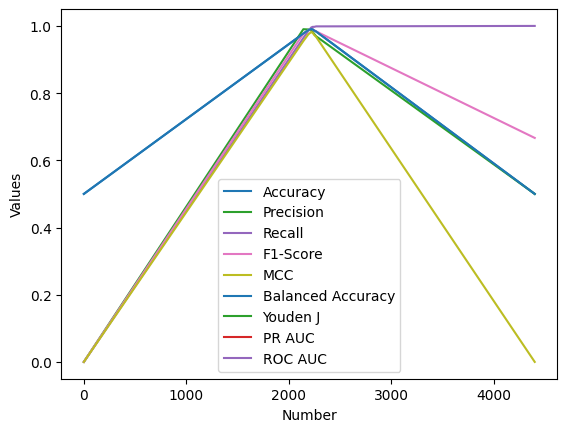

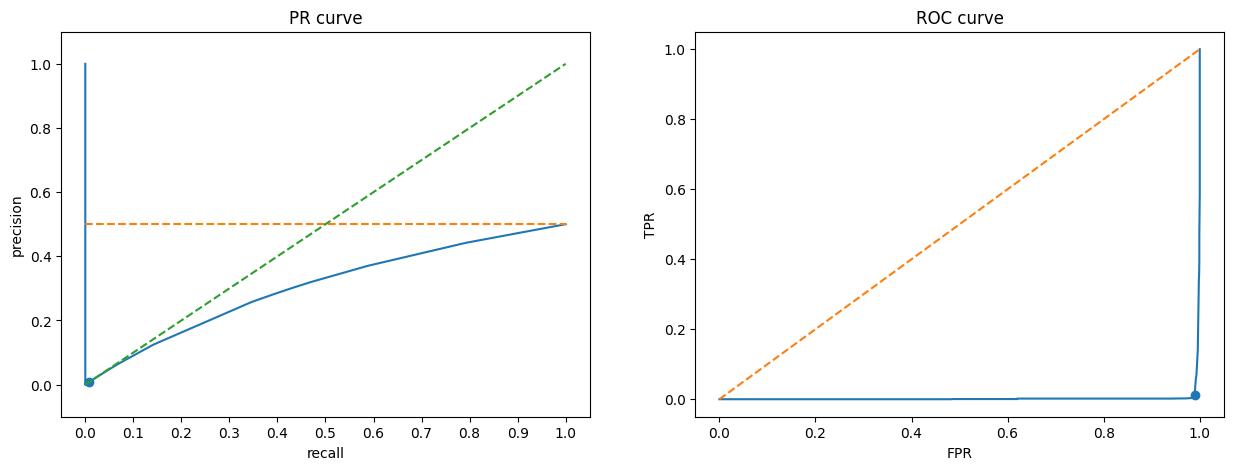

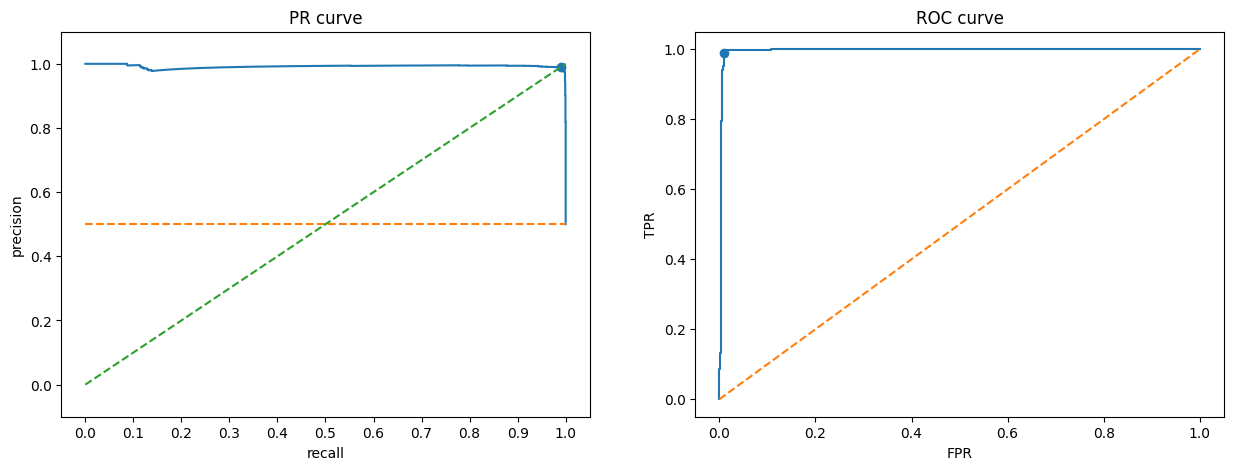

In [170]:
diagram(df, metric_result)

In [171]:
birthday = "28-12"
K = int(birthday.split("-")[0]) % 4
remove = 50 + 10 * K
objects_to_remove  = len(df[df["GT"] == 1]) * (remove / 100)
indices_to_remove = np.random.choice(df[df["GT"] == 1].index, size=int(objects_to_remove), replace=False)
new_df = df.drop(indices_to_remove)

persent = 1 - new_df['GT'].value_counts()[1] / df['GT'].value_counts()[1]
print(remove, "%")
print(new_df['GT'].value_counts())

50 %
GT
0    2200
1    1100
Name: count, dtype: int64


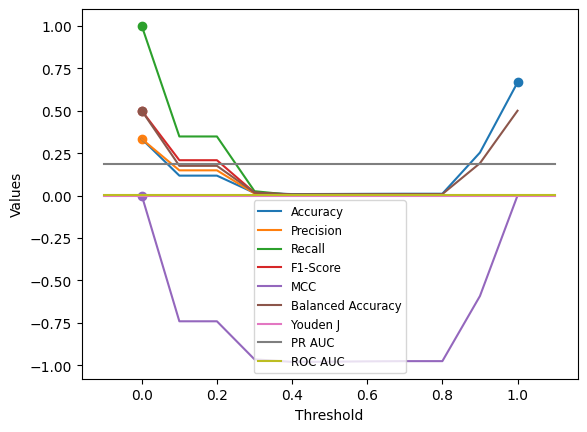

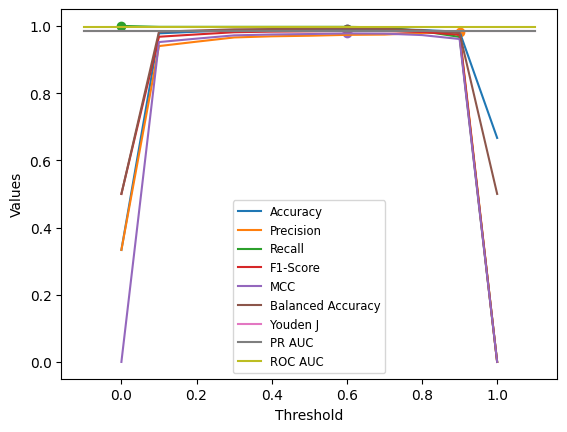

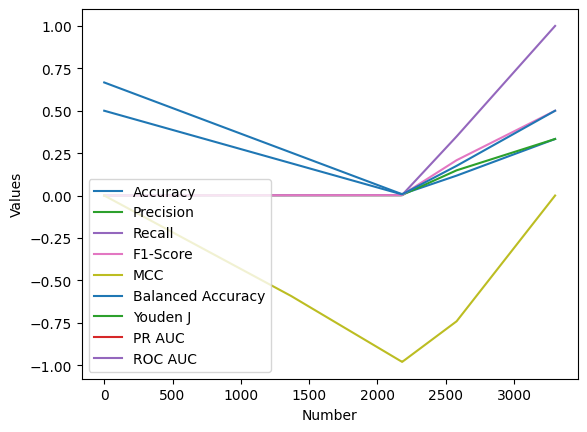

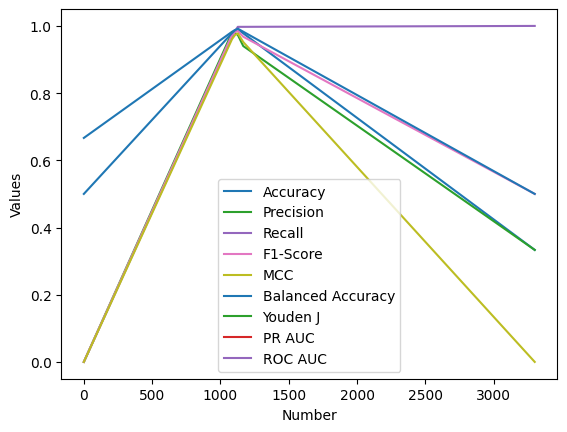

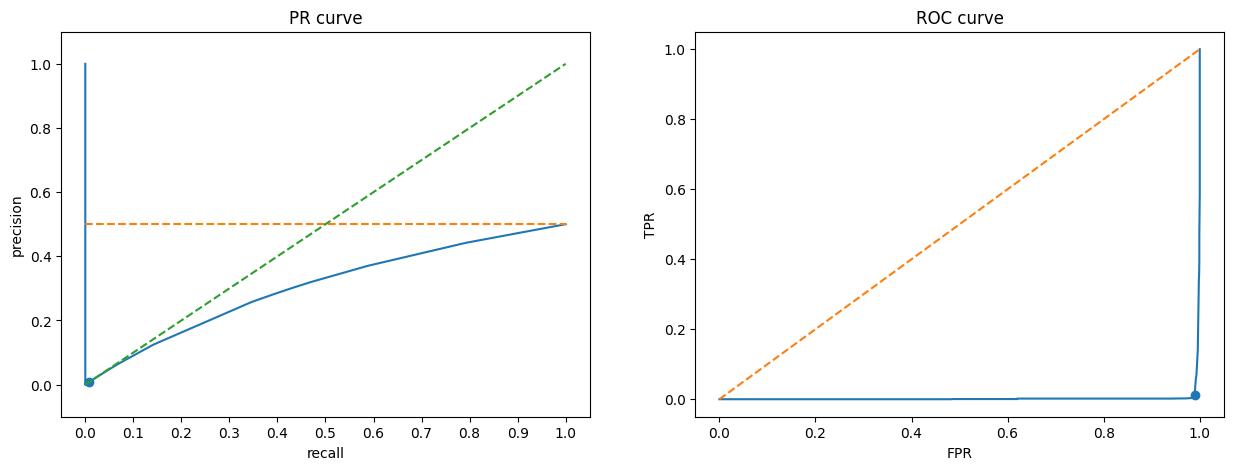

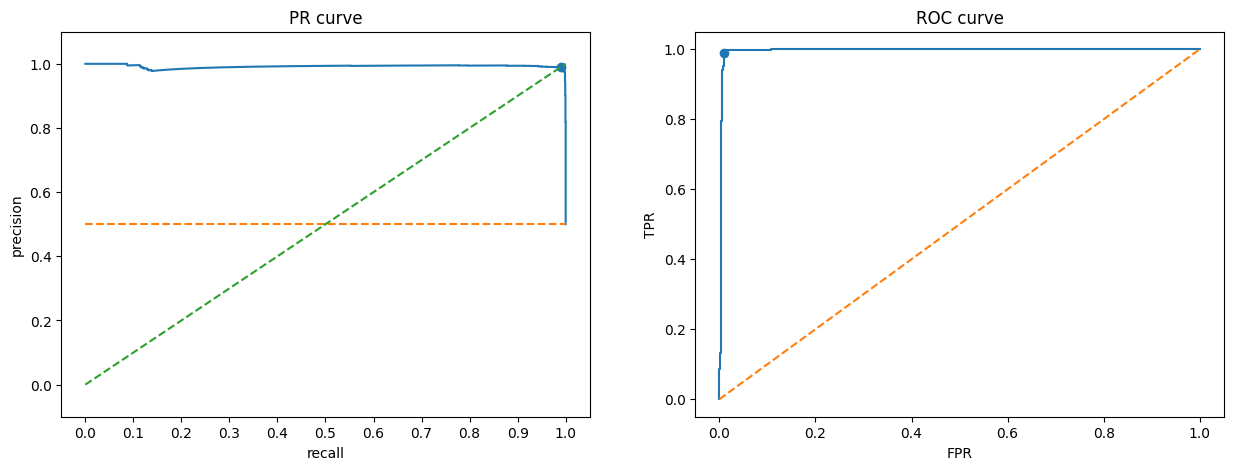

In [172]:
new_metric_result = calculate_metrics(new_df, metric_name)
diagram(df, new_metric_result)